<a href="https://colab.research.google.com/github/maxmelichov/eye-movmentprediction/blob/main/eye_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, Flatten,Dropout
from keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("data.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
need_col = ['Participant name','Presented Stimulus name','Recording start time','Recording resolution height','Recording resolution width','Gaze point left X (DACSmm)','Gaze point left Y (DACSmm)','Gaze point right X (DACSmm)','Gaze point right Y (DACSmm)']

Creating a new df only the needed columns

In [ ]:
new_df = pd.DataFrame()
for col in need_col:
    new_df = pd.concat([new_df,df[col]],axis=1)


Taking the relevent number of the participant

In [ ]:
new_df = new_df.loc[(new_df['Presented Stimulus name']=='Slide4')| (new_df['Presented Stimulus name']=='Slide5')]

In [ ]:
new_df.isna().sum()

Participant name                 0
Presented Stimulus name          0
Recording start time             0
Recording resolution height      0
Recording resolution width       0
Gaze point left X (DACSmm)     726
Gaze point left Y (DACSmm)     726
Gaze point right X (DACSmm)    604
Gaze point right Y (DACSmm)    604
dtype: int64

In [ ]:
new_df.dropna(axis =0 , inplace = True)
new_df.reset_index(inplace=True,drop=True)

In [ ]:
new_df.isna().sum()

Participant name               0
Presented Stimulus name        0
Recording start time           0
Recording resolution height    0
Recording resolution width     0
Gaze point left X (DACSmm)     0
Gaze point left Y (DACSmm)     0
Gaze point right X (DACSmm)    0
Gaze point right Y (DACSmm)    0
dtype: int64

In [ ]:
for col in new_df.columns[:2]:
    for i in range(len(new_df)):
        new_df[col][i] = int(new_df[col][i][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
new_df

,Participant name,Presented Stimulus name,Recording start time,Recording resolution height,Recording resolution width,Gaze point left X (DACSmm),Gaze point left Y (DACSmm),Gaze point right X (DACSmm),Gaze point right Y (DACSmm)
0,1,4,15:48:26.718,1080,1920,222.5,122.9,238.9,131.1
1,1,4,15:48:26.718,1080,1920,220.6,119.0,240.7,131.1
2,1,4,15:48:26.718,1080,1920,222.8,120.5,235.9,128.7
3,1,4,15:48:26.718,1080,1920,237.4,122.7,238.7,135.2
4,1,4,15:48:26.718,1080,1920,236.7,126.4,251.9,135.3
...,...,...,...,...,...,...,...,...,...
2218,2,5,15:53:16.560,1080,1920,471.9,215.2,458.4,215.6
2219,2,5,15:53:16.560,1080,1920,471.1,213.8,458.1,215.3
2220,2,5,15:53:16.560,1080,1920,464.4,212.4,457.6,218.1
2221,2,5,15:53:16.560,1080,1920,468.1,213.4,455.9,224.2


converting it to int

In [ ]:
new_df['Participant name']=new_df['Participant name'].astype("int16")
new_df['Presented Stimulus name']=new_df['Presented Stimulus name'].astype("int16")

Droping non int or float columns

In [ ]:
new_df.to_csv("DF.csv")

In [ ]:
df= pd.read_csv("DF.csv",parse_dates=['Recording start time'], index_col='Recording start time')

df.drop('Unnamed: 0',axis = 1,inplace=True)

**We had two different experiments**

Time line 1: Participant 1,4,5 

Time line 2: Participant 2,3,6,7

In [ ]:
Timeline1 = df.loc[(df['Participant name']==1) | (df['Participant name'] ==4) | (df['Participant name'] ==5)]

In [ ]:
Timeline1 =Timeline1.iloc[:,4:]

In [ ]:
Timeline1=np.array(Timeline1)

In [ ]:
Timeline1[40].shape

(4,)

In [ ]:
def datacreation(Timeline):
  window  = 30   #time series length
  skip    = 1
  next    = 10    #predict point in next steps

  x_data = []
  y_data = [] 

  for i in range( 0, len(Timeline) - window - next, skip ):
    x_data.append( Timeline[i:i+window] )
    y_data.append( Timeline[i+window+next] )

  x_data_np = np.array(x_data)
  y_data_np = np.array(y_data)

  print("x_data_np", x_data_np.shape,"y_data_np", y_data_np.shape)
  return x_data_np,y_data_np

In [ ]:
def dataengineering(x_data_np,y_data_np):
  #normalize
  scaler = MinMaxScaler(feature_range=(0, 1))
  x_data0 = scaler.fit_transform(x_data_np[:,:,0])
  x_data1 = scaler.fit_transform(x_data_np[:,:,1])

  y_data0 = scaler.fit_transform(y_data_np[:,0].reshape(-1,1))
  y_data1 = scaler.fit_transform(y_data_np[:,1].reshape(-1,1))

  x_data2 = scaler.fit_transform(x_data_np[:,:,2])
  x_data3 = scaler.fit_transform(x_data_np[:,:,3])

  y_data2 = scaler.fit_transform(y_data_np[:,2].reshape(-1,1))
  y_data3 = scaler.fit_transform(y_data_np[:,3].reshape(-1,1))
  # x_data0 = x_data_np[:,:,0] *1./1920
  # x_data1 = x_data_np[:,:,1] *1./1080
  # y_data0 = y_data_np[:,0] *1./1920
  # y_data1 = y_data_np[:,1] *1./1080

  # x_data2 = x_data_np[:,:,2] *1./1920
  # x_data3 = x_data_np[:,:,3] *1./1080

  # y_data2 = y_data_np[:,2] *1./1920
  # y_data3 = y_data_np[:,3] *1./1080	


  #exapnad dim
  x_data0 = x_data0.reshape((x_data0.shape[0],x_data0.shape[1],1))
  x_data1 = x_data1.reshape((x_data1.shape[0],x_data1.shape[1],1))

  y_data0 = y_data0.reshape((y_data0.shape[0],1))
  y_data1 = y_data1.reshape((y_data1.shape[0],1))

  x_data2 = x_data0.reshape((x_data2.shape[0],x_data2.shape[1],1))
  x_data3 = x_data1.reshape((x_data3.shape[0],x_data3.shape[1],1))
  
  y_data2 = y_data2.reshape((y_data2.shape[0],1))
  y_data3 = y_data3.reshape((y_data3.shape[0],1))


  


  #final array normalized
  x_data = np.concatenate((x_data0,x_data1,x_data2,x_data3),axis=2)
  y_data = np.concatenate((y_data0,y_data1,y_data2,y_data3),axis=1)


  #Check correctness
  print("y_data", y_data.shape,"x_data", x_data.shape)

  print(np.min(x_data[:,:,0]))
  print(np.min(x_data[:,:,1]))
  print(np.max(x_data[:,:,2]))
  print(np.max(x_data[:,:,3]))

  print(np.min(y_data[:,0]))
  print(np.min(y_data[:,1]))
  print(np.max(y_data[:,2]))
  print(np.max(y_data[:,3]))
  return x_data,y_data


In [ ]:
def test_train_split(x_data,y_data):
  #Train on the start of sequence ; test on the end of sequence
  index = int(x_data.shape[0]*0.8)

  X_train = x_data[:index,:,:]
  X_val = x_data[index:,:,:]

  Y_train = y_data[:index,:]
  Y_val = y_data[index:,:] 

  print('Train set shape', X_train.shape)
  print('Validation set shape', X_val.shape)
  print("y_train set shape",Y_train.shape)
  print('Validation label shape', Y_val.shape)
  return X_train,X_val,Y_train,Y_val

In [ ]:
def get_model(X_train,Y_train):

#   model_lstm= keras.Sequential()

#   model_lstm.add(keras.layers.LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model_lstm.add(keras.layers.Dropout(rate=0.5))

#   model_lstm.add(keras.layers.RepeatVector(n=X_train.shape[2]))
#   model_lstm.add(keras.layers.LSTM(units=32,return_sequences=True))

#   model_lstm.add(keras.layers.Dropout(rate=0.5))

#   model_lstm.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Y_train.shape[1])))
#   model_lstm.add(keras.layers.Flatten())
#   model_lstm.add(Dense(32))
#   model_lstm.add(Dense(Y_train.shape[1],activation='linear'))
#   model_lstm.compile(loss='mae',optimizer ='adam')
  model_lstm = Sequential()
  model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #layer 1
  model_lstm.add(LSTM(32, return_sequences=True)) # layer 2
  model_lstm.add(LSTM(16))
  model_lstm.add(Dense(64)) 
  model_lstm.add(Dense(Y_train.shape[1],activation='linear'))
  model_lstm.compile(loss='mse', optimizer='adam')
  return model_lstm

In [ ]:
x_data_np,y_data_np= datacreation(Timeline1)
x_data,y_data = dataengineering(x_data_np,y_data_np)
X_train,X_val,Y_train,Y_val = test_train_split(x_data,y_data) 
model_lstm = get_model(X_train,Y_train)
lstm_history = model_lstm.fit(X_train, Y_train, validation_data=(X_val, Y_val),
epochs=50, verbose=2,batch_size = 16,
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)])

x_data_np (2146, 30, 4) y_data_np (2146, 4)
y_data (2146, 4) x_data (2146, 30, 4)
0.0
0.0
1.0
1.0
0.0
0.0
0.9999999999999999
1.0
Train set shape (1716, 30, 4)
Validation set shape (430, 30, 4)
y_train set shape (1716, 4)
Validation label shape (430, 4)
Epoch 1/50
108/108 - 12s - loss: 0.0375 - val_loss: 0.0322 - 12s/epoch - 112ms/step
Epoch 2/50
108/108 - 5s - loss: 0.0102 - val_loss: 0.0322 - 5s/epoch - 45ms/step
Epoch 3/50
108/108 - 5s - loss: 0.0092 - val_loss: 0.0311 - 5s/epoch - 46ms/step
Epoch 4/50
108/108 - 5s - loss: 0.0088 - val_loss: 0.0307 - 5s/epoch - 45ms/step
Epoch 5/50
108/108 - 5s - loss: 0.0084 - val_loss: 0.0288 - 5s/epoch - 46ms/step
Epoch 6/50
108/108 - 5s - loss: 0.0079 - val_loss: 0.0286 - 5s/epoch - 44ms/step
Epoch 7/50
108/108 - 5s - loss: 0.0078 - val_loss: 0.0283 - 5s/epoch - 44ms/step
Epoch 8/50
108/108 - 5s - loss: 0.0076 - val_loss: 0.0274 - 5s/epoch - 44ms/step
Epoch 9/50
108/108 - 5s - loss: 0.0077 - val_loss: 0.0267 - 5s/epoch - 45ms/step
Epoch 10/50
108

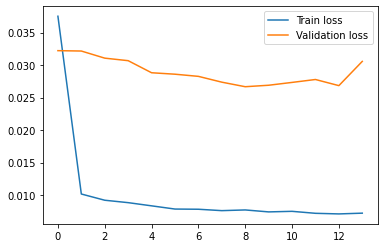

In [ ]:
plot(lstm_history.history['loss'], label='Train loss')
plot(lstm_history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
loss = model_lstm.evaluate(X_val, Y_val, verbose=0)
print('MAE: %f' % loss)

MAE: 0.026681


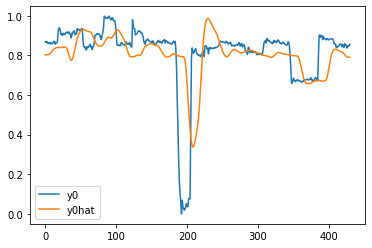

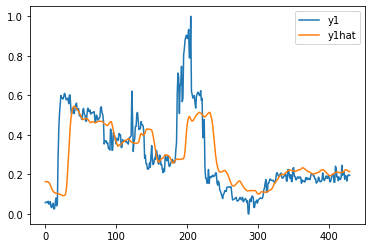

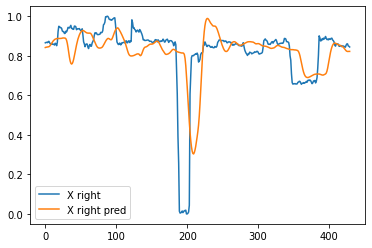

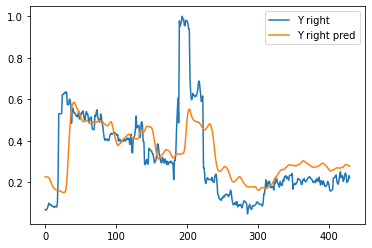

In [ ]:
#X left  axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,0], label='y0')
plt.plot(yhat[:,0], label='y0hat')
plt.legend()
plt.show()

#Y left axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,1], label='y1')
plt.plot(yhat[:,1], label='y1hat')
plt.legend()
plt.show()

#X right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,2], label='X right')
plt.plot(yhat[:,2], label='X right pred')
plt.legend()
plt.show()

#Y right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,3], label='Y right')
plt.plot(yhat[:,3], label='Y right pred')
plt.legend()
plt.show()



In [ ]:
Timeline2 = df.loc[(df['Participant name']==2) | (df['Participant name'] ==3) | (df['Participant name'] ==6)| (df['Participant name'] ==7)]

In [ ]:
Timeline2 =Timeline2.iloc[:,4:]
Timeline2=np.array(Timeline2)

In [ ]:
Timeline2.shape

(5266, 4)

In [ ]:
x_data_np,y_data_np= datacreation(Timeline2)
x_data,y_data = dataengineering(x_data_np,y_data_np)
X_train,X_val,Y_train,Y_val = test_train_split(x_data,y_data) 
model_lstm = get_model(X_train,Y_train)
lstm_history = model_lstm.fit(X_train, Y_train, validation_data=(X_val, Y_val),
epochs=50, verbose=2,batch_size = 32,
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience =5, restore_best_weights = True)])

x_data_np (5226, 30, 4) y_data_np (5226, 4)
y_data (5226, 4) x_data (5226, 30, 4)
0.0
0.0
1.0000000000000002
1.0000000000000002
0.0
0.0
0.9999999999999999
1.0
Train set shape (4180, 30, 4)
Validation set shape (1046, 30, 4)
y_train set shape (4180, 4)
Validation label shape (1046, 4)
Epoch 1/50
66/66 - 8s - loss: 0.0442 - val_loss: 0.0049 - 8s/epoch - 120ms/step
Epoch 2/50
66/66 - 3s - loss: 0.0115 - val_loss: 0.0042 - 3s/epoch - 38ms/step
Epoch 3/50
66/66 - 2s - loss: 0.0108 - val_loss: 0.0038 - 2s/epoch - 37ms/step
Epoch 4/50
66/66 - 3s - loss: 0.0102 - val_loss: 0.0035 - 3s/epoch - 38ms/step
Epoch 5/50
66/66 - 3s - loss: 0.0098 - val_loss: 0.0033 - 3s/epoch - 39ms/step
Epoch 6/50
66/66 - 2s - loss: 0.0097 - val_loss: 0.0046 - 2s/epoch - 37ms/step
Epoch 7/50
66/66 - 2s - loss: 0.0095 - val_loss: 0.0042 - 2s/epoch - 37ms/step
Epoch 8/50
66/66 - 2s - loss: 0.0094 - val_loss: 0.0047 - 2s/epoch - 37ms/step
Epoch 9/50
66/66 - 3s - loss: 0.0092 - val_loss: 0.0035 - 3s/epoch - 39ms/step
Epo

In [ ]:
loss = model_lstm.evaluate(X_val, Y_val, verbose=0)
print('MAE: %f' % loss)


MAE: 0.003315


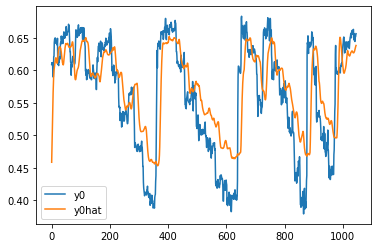

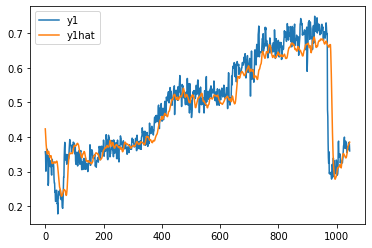

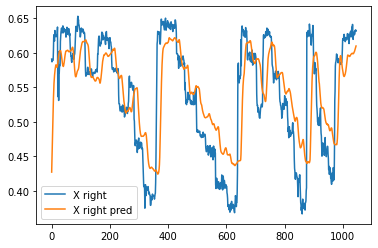

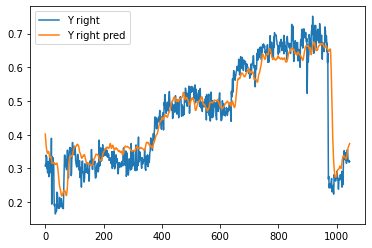

In [ ]:
#X left  axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,0], label='y0')
plt.plot(yhat[:,0], label='y0hat')
plt.legend()
plt.show()

#Y left axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,1], label='y1')
plt.plot(yhat[:,1], label='y1hat')
plt.legend()
plt.show()

#X right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,2], label='X right')
plt.plot(yhat[:,2], label='X right pred')
plt.legend()
plt.show()

#Y right axis value prediction
yhat = model_lstm.predict(X_val, verbose=0)
plt.plot(Y_val[:,3], label='Y right')
plt.plot(yhat[:,3], label='Y right pred')
plt.legend()
plt.show()
